In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split , Dataset
from torchvision import models, transforms, datasets
from PIL import Image
from sklearn.metrics import confusion_matrix
import csv

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


***CONSTANTS***

In [2]:
train_dir = '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/train'
num_classes = 65
image_shape = (224, 224)

***PREPROCESSING***

In [3]:
class MakeDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=lambda x: int(x))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(image_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
dataset = MakeDataset(train_dir, transform=transform)

In [6]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [7]:
batch_size = 8

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

***VISUALIZATION***

In [9]:
def show_images(images, labels, ncols=8):
    figure, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.set_title(f'Class: {labels[i]}')
        ax.axis('off')

In [10]:
data_iter = iter(train_loader)
images, labels = data_iter.__next__()

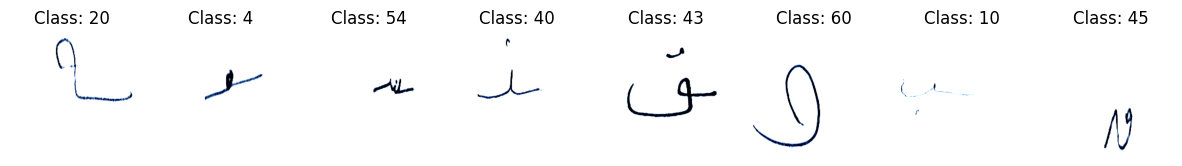

In [11]:
show_images(images, labels)
plt.show()

***MODEL***

In [12]:
model = models.efficientnet_b7(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:01<00:00, 180MB/s]


In [13]:

# Assuming the classifier attribute is 'classifier', get the last layer in the Sequential
last_layer = list(model.classifier.children())[-1]


# Replace it with the correct attribute name
if isinstance(last_layer, nn.Linear):
    in_features = last_layer.in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
else:
    raise ValueError("The last layer of the classifier is not Linear, please adjust the code accordingly.")

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
torch.cuda.empty_cache()

In [17]:
model = model.to(device)

In [18]:
num_epochs = 10
desired_training_accuracy = 99.999
early_stopping_threshold = 5  
early_stopping_counter = 0
best_val_loss = float('inf')

In [19]:
# Lists to store training and validation metrics for plotting curves
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
predictions = []
targets = []

In [20]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Print training loss and accuracy every 100 batches
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, '
                  f'Training Loss: {running_loss / 100}, Training Accuracy: {100 * correct_train / total_train}')
            running_loss = 0.0

    # Calculate training accuracy after the epoch
    training_accuracy = correct_train / total_train

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

            # Append predictions and targets for confusion matrix
            predictions.append(predicted_val.cpu().numpy())
            targets.append(labels.cpu().numpy())

    # Calculate validation accuracy after the epoch
    validation_accuracy = correct_val / total_val
    average_val_loss = val_running_loss / len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {running_loss / len(train_loader)}, '
          f'Training Accuracy: {100 * training_accuracy}%, '
          f'Validation Loss: {average_val_loss}, '
          f'Validation Accuracy: {100 * validation_accuracy}%')

    # Append training and validation metrics for plotting
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(training_accuracy)
    val_losses.append(average_val_loss)
    val_accuracies.append(validation_accuracy)

    scheduler.step()

Epoch 1/10, Batch 100/4256, Training Loss: 4.126889822483062, Training Accuracy: 4.25
Epoch 1/10, Batch 200/4256, Training Loss: 3.746554260253906, Training Accuracy: 9.125
Epoch 1/10, Batch 300/4256, Training Loss: 3.0499612951278685, Training Accuracy: 15.166666666666666
Epoch 1/10, Batch 400/4256, Training Loss: 2.382437504529953, Training Accuracy: 22.4375
Epoch 1/10, Batch 500/4256, Training Loss: 1.752634922862053, Training Accuracy: 29.775
Epoch 1/10, Batch 600/4256, Training Loss: 1.3815501177310943, Training Accuracy: 36.083333333333336
Epoch 1/10, Batch 700/4256, Training Loss: 1.1301019006967545, Training Accuracy: 41.392857142857146
Epoch 1/10, Batch 800/4256, Training Loss: 0.8796355098485946, Training Accuracy: 46.046875
Epoch 1/10, Batch 900/4256, Training Loss: 0.77730827242136, Training Accuracy: 49.958333333333336
Epoch 1/10, Batch 1000/4256, Training Loss: 0.6746529269218445, Training Accuracy: 53.25
Epoch 1/10, Batch 1100/4256, Training Loss: 0.6699953646957875, Tra

In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {100 * test_accuracy}%')

Test Accuracy: 97.04016913319239%


***VISUALIZE THE MODEL***

In [22]:
# Plotting loss and accuracy curves
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

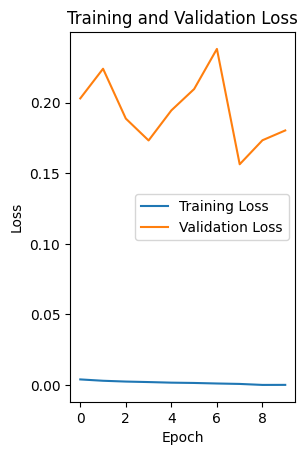

In [23]:
# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

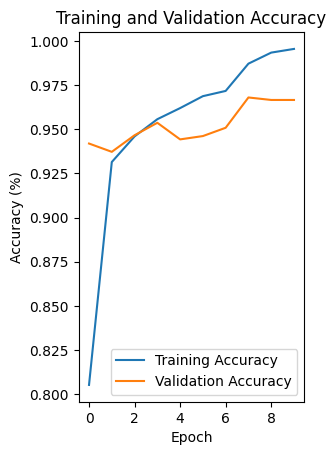

In [24]:
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

In [25]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(np.concatenate(predictions), np.concatenate(targets))
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[718   0   0 ...   0   0   0]
 [  0 692   0 ...   0   0   0]
 [  0   0 661 ...   0   0   9]
 ...
 [  0   0   0 ... 609   0  18]
 [  0   0   0 ...   2 651   0]
 [  0   0   0 ...  49   0 498]]


***PREDICTIONS***

In [27]:
model = model
model = model.cuda()

test_directory =  '/kaggle/input/arabic-letters-classification/Final_Arabic_Alpha_dataset/Final_Arabic_Alpha_dataset/test/'
csv_file_path = 'predictions.csv'

transform = transforms.Compose([
    transforms.Resize(image_shape),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)

    csv_writer.writerow(['ID', 'Label'])

    for filename in sorted(os.listdir(test_directory), key=lambda x: int(x.split('.')[0])):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(test_directory, filename)

            input_image = Image.open(image_path).convert('RGB')  
            input_tensor = transform(input_image).unsqueeze(0)
            input_tensor = input_tensor.cuda()

            with torch.no_grad():
                output = model(input_tensor)

            _, predicted_class = torch.max(output, 1)

            csv_writer.writerow([int(filename.split('.')[0]), predicted_class.item()])

print(f"Predictions saved to: {csv_file_path}")

Predictions saved to: predictions.csv
